# Cluster characterization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
import spacy
import multiprocessing
from tqdm import tqdm
import ast


# Text preprocessiong
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# Topic model
from bertopic import BERTopic

# Dimension reduction
from umap import UMAP

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\davis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\davis\miniconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

In [15]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_clustered = pd.read_csv("../data/core_users_clustered.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})
tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
                     # nrows = 400000,
                     parse_dates=['created_at'],
                     converters={"user_id": str,
                                 "tweet_id": str},
                     date_parser=dateparse,
                     lineterminator='\n')
scores = pd.read_csv("../data/scores_tweets.csv",
                    converters={"tweet_id": str})

scores = scores[(scores['tweet_id'].isin(tweets['tweet_id']))]
tweets = tweets.merge(scores, on='tweet_id', how='left')

C:\Users\davis\AppData\Local\Temp\ipykernel_2980\4191791815.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file


In [17]:
core_users_characterization = core_users_clustered.copy()
tweets_copy = tweets.copy()

## Caratterizzazione in base agli utenti

### Media dei valori delle caratteristiche per ogni cluster

In [8]:
mean_values = core_users_characterization.groupby('kmeans_cluster').mean(numeric_only=True)
mean_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
mean_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,followers_ratio,following_ratio,tweet_ratio,retweet_ratio,reply_ratio,db_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,
0,4.905181e+03,1160.334705,36436.961545,38.461465,42747.458300,0.020256,0.0,1.001266,1.045735,1.389875,0.044179,1.057291,27.184536,4.507714,0.754001,-0.077860,6319
1,1.000000e+00,167.500000,324.000000,0.000000,1192.000000,0.000000,0.0,1.000000,1.000000,0.263033,48.300000,0.194841,2.128267,76.000000,NaN,-1.000000,2
2,1.609278e+06,1202.071429,3423.571429,6453.857143,364334.571429,0.928571,0.0,1.000000,1.000000,0.011832,0.000001,0.299722,89.709413,1.424702,0.099846,-1.000000,14
3,8.029048e+03,4068.684766,224095.401207,92.446456,251884.001508,0.007541,0.0,1.001508,1.087481,1.703419,0.000627,2.605854,135.028217,5.713994,0.156693,-0.662142,663
4,1.004137e+05,100425.000000,539441.666667,2474.000000,767965.333333,0.000000,0.0,1.000000,1.000000,0.846709,0.000021,131.512326,1285.343946,1.404589,0.114199,-1.000000,3
5,2.060000e+02,627.000000,242737.000000,10.000000,198096.000000,0.000000,0.0,2.000000,1.000000,1.225350,0.014775,-24.115385,-7619.076923,2.724324,NaN,-1.000000,1
6,7.960000e+02,803.500000,42751.000000,0.000000,30985.000000,0.000000,0.0,1.000000,35.000000,1.120742,0.001399,6.012908,230.964576,0.833775,1.157972,-1.000000,2
7,2.299000e+03,2188.833333,54178.333333,4.666667,273.333333,0.000000,0.0,1.166667,1.500000,241.570578,0.067992,5.107377,0.665082,0.660178,0.398422,-1.000000,6


#### Descrizione clusters

- cluster 0: uno dei due cluster con la quanità più alta di utenti, con un numero medio di followers, following e liked_tweets, e un following ratio medio. Inoltre possiede un numero di lists e tweets relativamente basso a confronto degli alri cluster. Si può anche considerare che è un cluster misto tra utenti verificati e non verificati, con una maggioranza di utenti non verificati.
- cluster 1: appartiene al gruppo dei cluster con meno utenti, infatti è composto da soli 2 utenti. Questi utenti hanno un numero di followers, following, liked_tweets, following ratio e numero di tweets molto basso. Inoltre possiedono un numero di lists nullo. Si può anche considerare che è un cluster di soli utenti non verificati.
- cluster 2: fa anch'esso parte del gruppo con pochi utenti, ma è quello più numeroso tra questi clusters con 14 utenti. Questi utenti hanno un numero di followers, tweets e lists molto alto, mentre following, liked_tweets e following ratio relativamente bassi. Si può anche considerare che è un cluster di utenti quasi tutti verificati.
- cluster 3: è l'altro cluster dei 2 che contiene il maggior numero di utenti. Questi utenti hanno un numero di followers, following, lists e following ratio nella media. Mentre un numero di liked_tweets e numero di tweets molto alto. Si può anche considerare che è un cluster misto di utenti verificati e non, con prevalenza di utenti non verificati.
- cluster 4:

### Mediana dei valori delle caratteristiche per ogni cluster

In [15]:
median_values = core_users_characterization.groupby('kmeans_cluster').median(numeric_only=True)
median_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
median_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,followers_ratio,following_ratio,tweet_ratio,retweet_ratio,reply_ratio,db_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,
0,657.0,659.0,22900.0,3.0,28111.0,0.0,0.0,1.0,1.0,0.936413,1.644708e-03,0.352360,15.940470,1.800000,0.089170,0.0,6319
1,1.0,167.5,324.0,0.0,1192.0,0.0,0.0,1.0,1.0,0.263033,4.830000e+01,0.194841,2.128267,76.000000,NaN,-1.0,2
2,1431429.5,394.5,1400.0,6608.0,235301.5,1.0,0.0,1.0,1.0,0.004239,2.564709e-10,0.087390,58.553474,0.073822,0.080380,-1.0,14
3,3169.0,2532.0,201500.0,26.0,182567.0,0.0,0.0,1.0,1.0,1.134524,2.137966e-04,1.100678,86.210356,3.063830,0.039867,-1.0,663
4,92889.0,93259.0,175951.0,578.0,226439.0,0.0,0.0,1.0,1.0,0.777035,1.080842e-05,59.411615,667.965956,0.711340,0.033041,-1.0,3
5,206.0,627.0,242737.0,10.0,198096.0,0.0,0.0,2.0,1.0,1.225350,1.477484e-02,-24.115385,-7619.076923,2.724324,NaN,-1.0,1
6,796.0,803.5,42751.0,0.0,30985.0,0.0,0.0,1.0,35.0,1.120742,1.399339e-03,6.012908,230.964576,0.833775,1.157972,-1.0,2
7,827.5,616.5,35342.0,2.5,173.0,0.0,0.0,1.0,1.0,222.004082,9.617979e-04,0.362650,0.314365,0.428395,0.347826,-1.0,6


### Varianza dei valori delle caratteristiche per ogni cluster

In [16]:
var_values = core_users_characterization.groupby('kmeans_cluster').var(numeric_only=True)
var_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
var_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,followers_ratio,following_ratio,tweet_ratio,retweet_ratio,reply_ratio,db_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,
0,1.178275e+09,1.949626e+06,1.633513e+09,2.613983e+04,1.899937e+09,0.019849,0.0,0.001581,0.099364,3.966344,3.145922e-01,11.222264,1.627994e+03,208.879125,36.530539,0.109480,6319
1,2.000000e+00,3.406050e+04,1.331280e+05,0.000000e+00,5.202000e+03,0.000000,0.0,0.000000,0.000000,0.084205,2.553800e+02,0.018499,1.672254e+00,NaN,NaN,0.000000,2
2,8.033929e+11,3.437623e+06,3.753831e+07,6.462464e+06,1.327831e+11,0.071429,0.0,0.000000,0.000000,0.000363,3.029083e-11,0.199550,8.371459e+03,14.651133,0.014668,0.000000,14
3,9.212598e+08,4.436760e+07,2.538778e+10,6.481100e+04,8.593973e+10,0.007496,0.0,0.001508,0.593544,11.007002,9.119138e-06,35.633541,2.868043e+04,360.609553,0.366006,0.773897,663
4,6.820859e+09,6.793381e+09,4.275492e+11,1.430376e+07,1.036642e+12,0.000000,0.0,0.000000,0.000000,0.049962,4.797997e-10,22257.203349,2.691322e+06,1.604680,0.028138,0.000000,3
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,1.270080e+05,1.378125e+05,2.624791e+09,0.000000e+00,1.955846e+08,0.000000,0.0,0.000000,200.000000,1.317029,3.676577e-07,45.215649,6.617821e+04,0.999106,2.286807,0.000000,2
7,9.276482e+06,9.543534e+06,1.059254e+09,2.666667e+01,5.226627e+04,0.000000,0.0,0.166667,1.500000,6900.151665,2.645950e-02,110.647686,5.582213e-01,0.583646,0.109074,0.000000,6


### Deviazione standard dei valori delle caratteristiche per ogni cluster

In [17]:
std_values = core_users_characterization.groupby('kmeans_cluster').std(numeric_only=True)
std_values['n_users'] = core_users_characterization.groupby('kmeans_cluster')['user_id'].count()
std_values


,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,nbr_accounts,nbr_usernames,favorites_ratio,followers_ratio,following_ratio,tweet_ratio,retweet_ratio,reply_ratio,db_cluster,n_users
kmeans_cluster,,,,,,,,,,,,,,,,,
0,34326.014656,1396.290078,40416.746151,161.678163,4.358827e+04,0.140887,0.0,0.039764,0.315221,1.991568,0.560885,3.349965,40.348411,14.452651,6.044050,0.330877,6319
1,1.414214,184.554870,364.867099,0.000000,7.212489e+01,0.000000,0.0,0.000000,0.000000,0.290181,15.980613,0.136011,1.293157,NaN,NaN,0.000000,2
2,896321.871226,1854.082749,6126.851880,2542.137679,3.643941e+05,0.267261,0.0,0.000000,0.000000,0.019058,0.000006,0.446711,91.495675,3.827680,0.121110,0.000000,14
3,30352.261514,6660.900834,159335.446089,254.580052,2.931548e+05,0.086579,0.0,0.038837,0.770418,3.317680,0.003020,5.969384,169.352971,18.989722,0.604984,0.879714,663
4,82588.492039,82421.969225,653872.442198,3782.031332,1.018156e+06,0.000000,0.0,0.000000,0.000000,0.223521,0.000022,149.188483,1640.525045,1.266760,0.167744,0.000000,3
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,356.381818,371.231060,51232.714724,0.000000,1.398516e+04,0.000000,0.0,0.000000,14.142136,1.147619,0.000606,6.724258,257.251261,0.999553,1.512219,0.000000,2
7,3045.731833,3089.261104,32546.185317,5.163978,2.286182e+02,0.000000,0.0,0.408248,1.224745,83.067152,0.162664,10.518920,0.747142,0.763967,0.330264,0.000000,6


### Distribuzione delle caratteristiche per ogni cluster

#### Distribuzione del following_ratio per ogni cluster

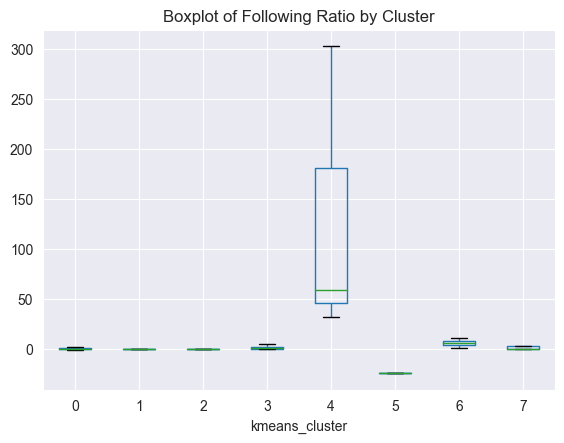

In [8]:
# # Facciamo un loop attraverso ogni cluster e creiamo un box plot per ciascuno
# for cluster in core_users_characterization['kmeans_cluster'].unique():
#     sns.boxplot(x=core_users_characterization[core_users_characterization['kmeans_cluster']==cluster]['following_ratio'])
#     plt.title(f'Box plot of following_ratio for cluster {cluster}')
#     plt.show()

core_users_characterization.boxplot(column='following_ratio', by='kmeans_cluster', showfliers=False)
plt.title('Boxplot of Following Ratio by Cluster')
plt.suptitle('')  # rimuove il titolo automatico generato da pandas
plt.show()


#### Distribuzione dei followers per ogni cluster

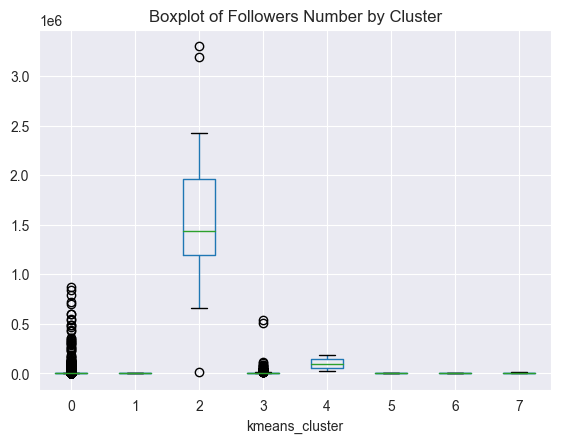

In [9]:
core_users_characterization.boxplot(column='nbr_followers', by='kmeans_cluster')
plt.title('Boxplot of Followers Number by Cluster')
plt.suptitle('')  # rimuove il titolo automatico generato da pandas
plt.show()


## Caratterizzazione in base ai tweet

In [18]:
# Unisci i DataFrame sulla base dell'user_id
tweets_copy = pd.merge(tweets_copy, core_users_characterization[['user_id', 'kmeans_cluster']], on='user_id', how='left')

### Media dei valori delle caratteristiche per ogni cluster

In [23]:
cluster_scores = tweets_copy.groupby('kmeans_cluster')[['toxicity', 'positive_y', 'negative_y']].describe()
cluster_scores

toxicity                                                    \
                   count      mean       std       min       25%       50%   
kmeans_cluster                                                               
0.0             569732.0  0.104555  0.136501  0.000514  0.012607  0.049730   
1.0                  1.0  0.015530       NaN  0.015530  0.015530  0.015530   
2.0               8251.0  0.032772  0.053652  0.000656  0.004278  0.012504   
3.0             156051.0  0.085361  0.126736  0.000547  0.007711  0.031661   
4.0               1609.0  0.079343  0.103506  0.000621  0.011482  0.038982   
5.0                  0.0       NaN       NaN       NaN       NaN       NaN   
6.0               1009.0  0.154634  0.149667  0.000874  0.038541  0.106684   
7.0                313.0  0.150084  0.138766  0.000829  0.047163  0.107468   

                                   positive_y            ...            \
                     75%       max      count      mean  ...       75%   
kmeans_cluster                                           ...             
0.0             0.143787  0.997949   552701.0  0.130277  ...  0.169962   
1.0             0.015530  0.015530        1.0  0.151690  ...  0.151690   
2.0             0.035996  0.575714     8250.0  0.048472  ...  0.048180   
3.0             0.109756  0.998258   151373.0  0.125980  ...  0.165311   
4.0             0.100831  0.786045     1577.0  0.138639  ...  0.167629   
5.0                  NaN       NaN        0.0       NaN  ...       NaN   
6.0             0.228890  0.898380      989.0  0.233613  ...  0.348816   
7.0             0.217781  0.787898      306.0  0.150683  ...  0.212440   

                         negative_y                                          \
                     max      count      mean       std       min       25%   
kmeans_cluster                                                                
0.0             0.998315   552701.0  0.221062  0.255616  0.000003  0.007035   
1.0             0.151690        1.0  0.473206       NaN  0.473206  0.473206   
2.0             0.977520     8250.0  0.071144  0.143038  0.000005  0.000319   
3.0             0.996590   151373.0  0.195757  0.242357  0.000004  0.004790   
4.0             0.994258     1577.0  0.139142  0.210139  0.000009  0.003457   
5.0                  NaN        0.0       NaN       NaN       NaN       NaN   
6.0             0.989204      989.0  0.337898  0.259451  0.000009  0.094917   
7.0             0.987486      306.0  0.308430  0.279730  0.000069  0.034467   

                                              
                     50%       75%       max  
kmeans_cluster                                
0.0             0.104136  0.386679  0.994099  
1.0             0.473206  0.473206  0.473206  
2.0             0.004820  0.064715  0.952953  
3.0             0.076850  0.330563  0.992405  
4.0             0.038122  0.183194  0.972707  
5.0                  NaN       NaN       NaN  
6.0             0.306026  0.560493  0.963623  
7.0             0.219362  0.541382  0.977773  

[8 rows x 24 columns]

### Confronto delle distribuzioni

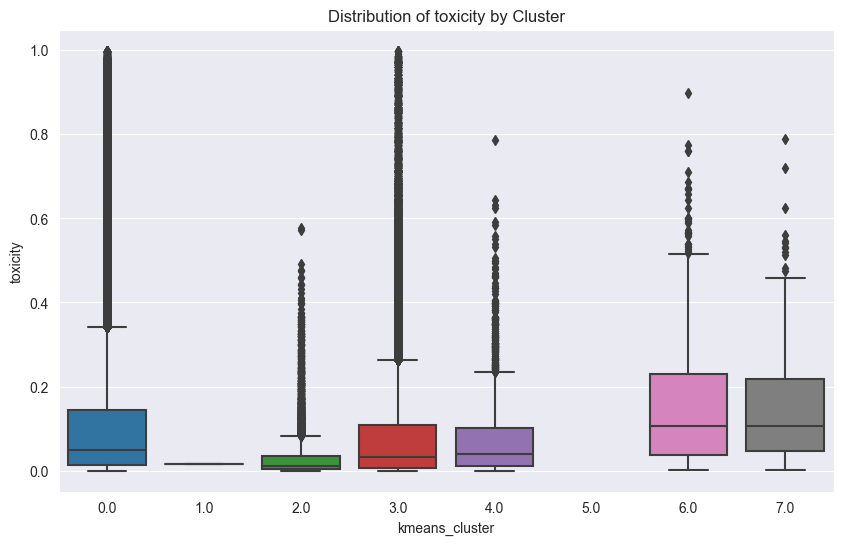

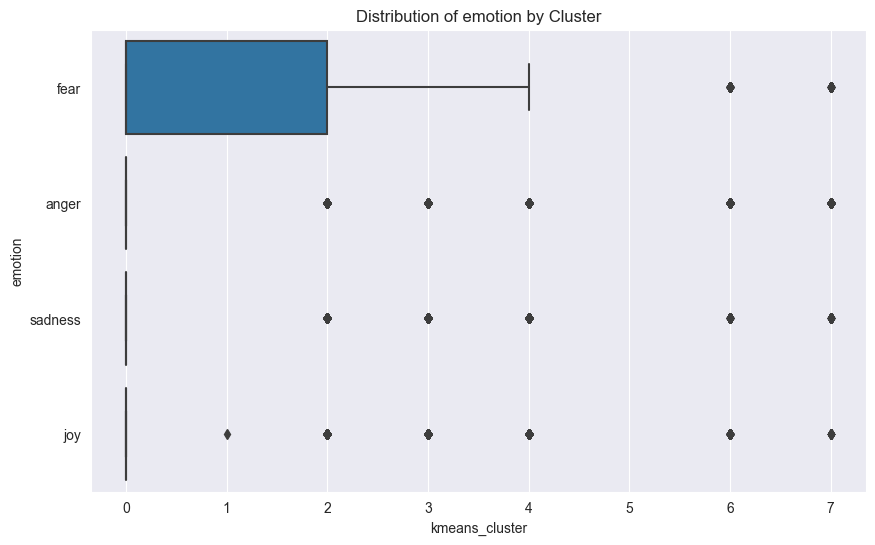

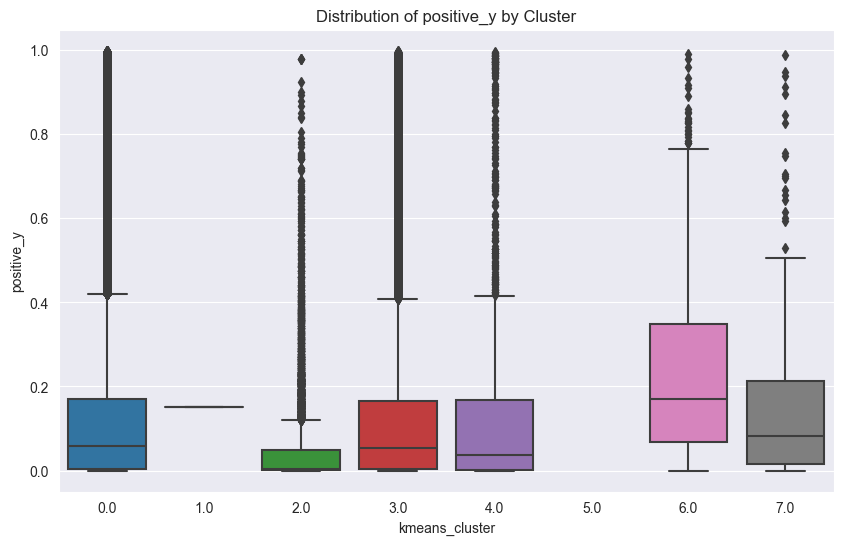

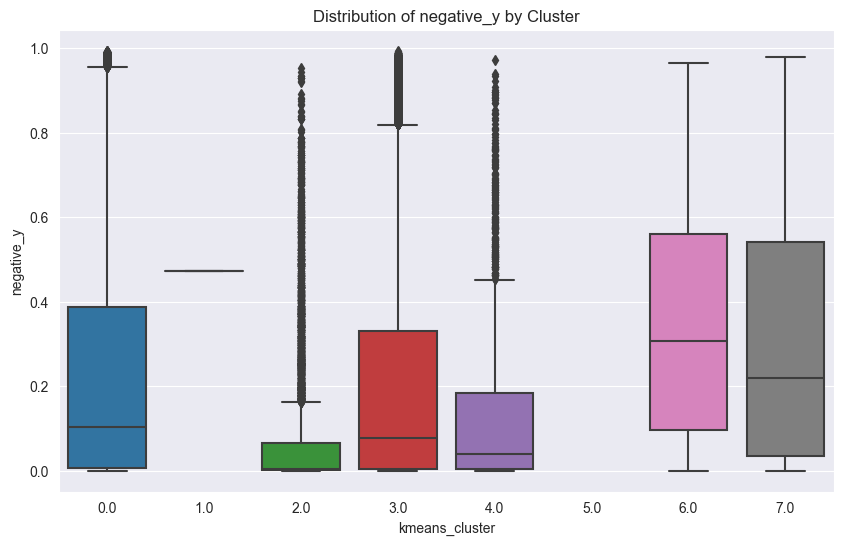

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

for score in ['toxicity', 'emotion', 'positive_y', 'negative_y']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='kmeans_cluster', y=score, data=tweets_copy)
    plt.title(f'Distribution of {score} by Cluster')
    plt.show()


### Test statistici

In [26]:
from scipy import stats

f_val, p_val = stats.f_oneway(tweets_copy[tweets_copy['kmeans_cluster'] == 0]['toxicity'],
                              tweets_copy[tweets_copy['kmeans_cluster'] == 1]['toxicity'],
                              tweets_copy[tweets_copy['kmeans_cluster'] == 2]['toxicity'])

print("ANOVA results: F=", f_val, ", P =", p_val)


ANOVA results: F= nan , P = nan


### Correlazioni

<Axes: >

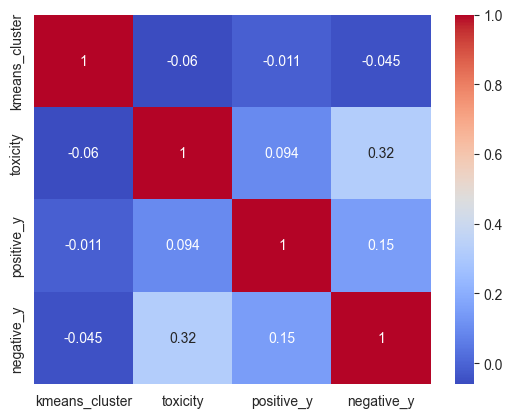

In [30]:
correlations = tweets_copy[['kmeans_cluster', 'toxicity', 'positive_y', 'negative_y']].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm')


## Distribuzione dei valori delle caratteristiche per ogni cluster

Il formato del DataFrame cluster_tweets, in ogni riga rappresenta un cluster e la colonna combined_text contiene una lista di tuple. Ogni tupla rappresenta una parola (o token) e il suo conteggio nel cluster.

In questo codice, utilizziamo la funzione nlp di spaCy per eseguire una serie di operazioni di elaborazione del linguaggio naturale sul testo, tra cui la tokenizzazione, la lemmatizzazione e la rimozione delle stop words. La funzione nlp restituisce un oggetto Doc che può essere iterato per ottenere ciascuna parola (o "token") nel testo. Per ciascun token, usiamo l'attributo lemma_ per ottenere la forma base della parola, e l'attributo is_alpha per escludere i segni di punteggiatura.

### Preprocessing dei dati

Preparazione dei dati per l'analisi del testo, creando un dataframe apposito.

In [4]:
# Unisci i due DataFrame sulla base del user_id
merged_df = pd.merge(tweets, core_users_characterization, on='user_id')

# Sostituisci i valori NaN con '' nelle colonne 'text', 'retweeted_text' e 'quoted_text'
merged_df['text'] = merged_df['text'].fillna('')
merged_df['retweeted_text'] = merged_df['retweeted_text'].fillna('')
merged_df['quoted_text'] = merged_df['quoted_text'].fillna('')

# Sostituisci 'https' con una stringa vuota nelle colonne 'text', 'retweeted_text' e 'quoted_text'
merged_df['text'] = merged_df['text'].str.replace('https', '')
merged_df['retweeted_text'] = merged_df['retweeted_text'].str.replace('https', '')
merged_df['quoted_text'] = merged_df['quoted_text'].str.replace('https', '')

# Assicurati che tutti i valori nelle colonne 'text', 'retweeted_text' e 'quoted_text' siano stringhe
merged_df['text'] = merged_df['text'].astype(str)
merged_df['retweeted_text'] = merged_df['retweeted_text'].astype(str)
merged_df['quoted_text'] = merged_df['quoted_text'].astype(str)

# Crea una nuova colonna 'combined_text' che combina i contenuti dei campi 'text', 'retweeted_text' e 'quoted_text'
merged_df['combined_text'] = merged_df.apply(lambda row: ' '.join([row['text'], row['retweeted_text'], row['quoted_text']]), axis=1)

# Rimuovi i spazi vuoti iniziali e finali e sostituisci più spazi con uno solo
merged_df['combined_text'] = merged_df['combined_text'].str.strip().replace(' +', ' ', regex=True)

# Crea un nuovo DataFrame dove ogni riga rappresenta un cluster e la colonna è una lista di tutti i tweet di quel cluster
cluster_tweets = merged_df.groupby('kmeans_cluster')['combined_text'].apply(list).reset_index()

cluster_tweets


,kmeans_cluster,combined_text
0,0,[Politici avvertiti: chi impone vaccini obblig...
1,1,[#Radioanchio @giorgiozanchini #22dicembre @Ra...
2,2,[Tutti i segreti del vaccino - #Buongiorno con...
3,3,[“Per ora” non prevedono di vaccinare i bambin...
4,4,[Vaccini e tracciamento #digitale ://t.co/VGuA...
5,5,[cos'è un immunodepresso raga? cioè è tipo uno...
6,6,[@Rosario04719767 Sono antivaccinaro viscerale...
7,7,[variante Covid(a parte il fatto che mi sembra...


### Lemmatizzazione dei testi

In [5]:
# Carica il modello italiano di spaCy disabilitando il NER
nlp = spacy.load('it_core_news_sm', disable=['ner', 'parser'])

stopwords = nltk.corpus.stopwords.words('italian')

def process_texts(text_list):
    processed_texts = []
    for text in tqdm(text_list, desc='Processing texts'):
        text = text.lower()
        doc = nlp(text)
        text_lemmatized = ' '.join([token.lemma_ for token in doc if token.text not in stopwords and not token.is_punct])
        processed_texts.append(text_lemmatized)
    return processed_texts

cluster_tweets['processed_texts'] = cluster_tweets['combined_text'].apply(lambda x: list(tqdm(process_texts(x), desc='Applying function')))

# Dai uno sguardo ai dati
cluster_tweets

Applying function: 100%|██████████| 952/952 [00:00<?, ?it/s]


,kmeans_cluster,combined_text,processed_texts
0,0,[Politici avvertiti: chi impone vaccini obblig...,[politico avvertire imporre vaccino obbligator...
1,1,[#Radioanchio @giorgiozanchini #22dicembre @Ra...,[radioanchio @giorgiozanchini 22dicembre @radi...
2,2,[Tutti i segreti del vaccino - #Buongiorno con...,[segreto vaccino buongiorno primapagino repubb...
3,3,[“Per ora” non prevedono di vaccinare i bambin...,[ora prevedere vaccinare bambino \n\n ora \n\n...
4,4,[Vaccini e tracciamento #digitale ://t.co/VGuA...,[vaccino tracciamento digitale //t.co vguar139...
5,5,[cos'è un immunodepresso raga? cioè è tipo uno...,[cosa immunodepresso raga cioè tipo costanteme...
6,6,[@Rosario04719767 Sono antivaccinaro viscerale...,[@rosario04719767 antivaccinaro viscerale prem...
7,7,[variante Covid(a parte il fatto che mi sembra...,[variare covid(a parte fatto sembrare pò tardi...


### Data saving

In [8]:
lemmatized_text = cluster_tweets[['kmeans_cluster', 'processed_texts']].copy()
# Salva il DataFrame in un file pickle
lemmatized_text.to_pickle("../data/lemmatized_text.pkl")

### Creazione del modello BERTopic

In [6]:
# Carica il DataFrame da file
lemmatized_text = pd.read_pickle("../data/lemmatized_text.pkl")

In [7]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Initiate BERTopic
topic_model = BERTopic(language="italian", calculate_probabilities=False)

# Create lists to store the topics and probabilities for each cluster
topics_list = []
probabilities_list = []

# Loop through each row in the DataFrame
for index, row in tqdm(lemmatized_text.iterrows(), total=lemmatized_text.shape[0]):
    # Run BERTopic model on the 'processed_texts' for this row
    topics, probabilities = topic_model.fit_transform(row['processed_texts'])
    # Append the topics and probabilities to the respective lists
    topics_list.append(topics)
    probabilities_list.append(probabilities)

# Add the topics and probabilities as new columns in the DataFrame
lemmatized_text['topics'] = topics_list
lemmatized_text['probabilities'] = probabilities_list


  0%|          | 0/8 [10:18:57<?, ?it/s]


MemoryError: Unable to allocate 12.2 GiB for an array with shape (1391063, 1179) and data type float64

### Estrazione delle parole chiave per ogni cluster

1. ```python
   common_words_per_cluster = {cluster: Counter(words).most_common() for cluster, words in cluster_tweets['words'].items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è una lista di tuple. Ogni tupla contiene una parola e la sua frequenza nel cluster. Counter(words).most_common() restituisce una lista delle parole più comuni insieme alla loro frequenza.
2. ```python
   all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words)
    ```
   all_common_words è un insieme di tutte le parole che sono comuni in qualsiasi cluster. Non stiamo cercando di rimuovere queste parole, stiamo solo creando un elenco di tutte le parole che sono comuni in qualsiasi cluster.
   La riga all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words) sta creando questo insieme.
   Tuttavia, nel punto 3, si utilizza all_common_words per trovare le parole uniche in ogni cluster. In particolare, all_common_words - set(word for word, _ in words) sta creando un insieme di parole che sono comuni in tutti i cluster tranne quello corrente. Quindi, se una parola è nel cluster corrente ma non in questo insieme, allora quella parola è unica per il cluster corrente.
   In questo modo, otteniamo le parole che sono più comuni in un determinato cluster, ma non sono comuni negli altri cluster.
3. ```python
   unique_common_words_per_cluster = {cluster: set(word for word, count in words if word not in all_common_words - set(word for word, _ in words)) for cluster, words in common_words_per_cluster.items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è un set di parole che sono più comuni solo in quel cluster specifico. Per ogni cluster, prende l'insieme di tutte le parole comuni (all_common_words) e ne rimuove le parole comuni di quel cluster, quindi verifica quali parole del cluster non fanno parte di questo insieme.
4. ```python
   unique_most_common_words_per_cluster = {cluster: [(word, count) for word, count in words if word in unique_common_words] for cluster, words in common_words_per_cluster.items()}
    ```
   Questa riga crea un dizionario dove ogni chiave è un identificatore di cluster e il valore è una lista di tuple. Ogni tupla contiene una parola e la sua frequenza nel cluster, ma solo per le parole che sono uniche per quel cluster (come identificato nella riga precedente).
5. ```python
   cluster_tweets['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)
    ```
   Infine, questa riga aggiunge i risultati al DataFrame esistente come una nuova colonna. Ogni cella in questa colonna sarà una lista di tuple, dove ogni tupla contiene una parola unica per quel cluster e la sua frequenza.



In [11]:
stop_words = set(stopwords.words('italian'))

def process_tweets(all_tweets):
    # Unisci tutti i tweet in un unico testo
    text = ' '.join(all_tweets)
    # Tokenizza il testo in parole
    words = nltk.word_tokenize(text)
    # Rimuovi le stop words e converti tutto in minuscolo
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    # # Calcola la frequenza di ciascuna parola
    # freq = Counter(words)
    # Restituisci le 10 parole più comuni
    return words

# Applica la funzione a ciascun cluster
cluster_tweets['words'] = cluster_tweets['combined_text'].apply(process_tweets)

# Prima creiamo un dizionario con le parole più comuni per ciascun cluster
common_words_per_cluster = {cluster: Counter(words) for cluster, words in cluster_tweets['words'].items()}

# Poi, creiamo un set con tutte le parole più comuni nei vari cluster
all_common_words = set(word for words in common_words_per_cluster.values() for word, count in words.keys())

# Trova le parole uniche per ciascun cluster
unique_words_per_cluster = {cluster: [word for word in words.keys() if word not in all_common_words - set(words.keys())] for cluster, words in common_words_per_cluster.items()}

# # Trova le parole più comuni uniche per ciascun cluster
# unique_most_common_words_per_cluster = {cluster: [(word, words[word]) for word in unique_words_per_cluster[cluster]] for cluster, words in common_words_per_cluster.items()}
# Trova le parole più comuni uniche per ciascun cluster
unique_most_common_words_per_cluster = {cluster: sorted([(word, words[word]) for word in unique_words_per_cluster[cluster]], key=lambda x: x[1], reverse=True)[:10] for cluster, words in common_words_per_cluster.items()}

# Aggiungiamo le parole più comuni uniche per ciascun cluster al DataFrame
cluster_tweets['most_common_unique_words'] = pd.Series(unique_most_common_words_per_cluster)

print(cluster_tweets['most_common_unique_words'])


KeyboardInterrupt: 

In [ ]:
# Stampa le 10 parole più comuni uniche per ciascun cluster
for k, words in unique_common_words_per_cluster.items():
    print(f'Cluster {k}: {words[:10]}')

In [ ]:
for index, row in cluster_tweets.iterrows():
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(dict(row['most_common_words']))

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Cluster {index} - Most Common Words')
    plt.show()
